In [104]:
import tensorflow as tf
import tensorflow_hub as hub
# For saving 'feature vectors' into a txt file
import numpy as np
# Glob for reading file names in a folder
import glob
import os.path
from tqdm import tqdm
import ntpath
import warnings
import cv2
from annoy import AnnoyIndex
from scipy import spatial
warnings.filterwarnings('ignore')
from operator import itemgetter

In [38]:
def load_img(path):
    # Reads the image file and returns data type of string
    img = tf.io.read_file(path)
    # Decodes the image to W x H x 3 shape tensor with type of uint8
    img = tf.io.decode_jpeg(img, channels=3)
    # Resizes the image to 224 x 224 x 3 shape tensor
    img = tf.image.resize_with_pad(img, 224, 224)
    # Converts the data type of uint8 to float32 by adding a new axis
    # img becomes 1 x 224 x 224 x 3 tensor with data type of float32
    # This is required for the mobilenet model we are using
    img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]

    return img

In [50]:
def match_id(filename):
    product_id = '_'.join(filename.split('_')[:-1])
    return product_id

In [3]:
image_paths= glob.glob('D:\\Documents\\Semester3\\ADM\\A3\\Images\\*.jpg')

In [51]:
def get_image_feature_vectors(path):
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    # Loops through all images in a local folder

    #print(path)
    # Loads and pre-process the image
    img = load_img(path)
    # Calculate the image feature vector of the img
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(filename) + ".npz"

    out_path = os.path.join('D:/Documents/Semester3/ADM/Assignment 3/Images/Images_Scraped/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')

In [52]:
def get_features(img, image_path): 
     # Definition of module with using tfhub.dev
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)
    #print(image_path)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(image_path) + ".npz"

    out_path = os.path.join('D:/Documents/Semester3/ADM/A3/Images/ImagesScraped/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')
    vector = np.loadtxt(out_path)
    return vector
    

In [198]:
image_paths= glob.glob('D:\\Documents\\Semester3\\ADM\\A3\\Images\\*.jpg')
#image_paths = glob.glob('D:\Downloads\Grass\\*jpg')
vectorfiles = glob.glob('D:\\Documents\\Semester3\\ADM\\A3\\Images\\ImagesScraped\\*.npz')
# compute styles
image_style_embeddings = {}

for image_path in tqdm(image_paths): 
    print(image_path)
    image_tensor = load_img(image_path)
    vector = get_features(image_tensor, image_path)
    image_style_embeddings[ntpath.basename(image_path)] = vector
    

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

D:\Downloads\Grass\1234_0.jpg


 25%|█████████████████████                                                               | 1/4 [00:04<00:14,  4.85s/it]

D:\Downloads\Grass\1234_1.jpg


 50%|██████████████████████████████████████████                                          | 2/4 [00:09<00:09,  4.88s/it]

D:\Downloads\Grass\1234_2.jpg


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:15<00:05,  5.04s/it]

D:\Downloads\Grass\1234_3.jpg


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]


In [193]:
def cluster():
    print("-------Annoy Index Generation----------------")
    # Defining data structures as empty dict
    file_index_to_file_name = {}
    file_index_to_file_vector = {}
    file_index_to_product_id = {}
    # Configuring annoy parameters
    dims = 1792
    n_nearest_neighbors = 20
    trees = 10000
    # Reads all file names which stores feature vectors
    allfiles = glob.glob('D:\\Documents\\Semester3\\ADM\\A3\\Images\\ImagesScraped\\*.npz')

    t = AnnoyIndex(dims, metric='angular')
    
    for file_index, i in enumerate(allfiles):
    # Reads feature vectors and assigns them into the file_vector 
        file_vector = np.loadtxt(i)

        # Assigns file_name, feature_vectors and corresponding product_id
        file_name = os.path.basename(i).split('.')[0]
        file_index_to_file_name[file_index] = file_name
        file_index_to_file_vector[file_index] = file_vector
        file_index_to_product_id[file_index] = match_id(file_name)

        # Adds image feature vectors into annoy index   
        t.add_item(file_index, file_vector)

        print("---------------------------------")
        print("Annoy index     : %s" %file_index)
        print("Image file name : %s" %file_name)
        print("Product id      : %s" %file_index_to_product_id[file_index])
        #print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))


    # Builds annoy index
    t.build(trees)

    print ("Step.1 - ANNOY index generation - Finished")
    print ("Step.2 - Similarity score calculation - Started ") 
  
    global named_nearest_neighbors
    named_nearest_neighbors = []

  # Loops through all indexed items
    for i in file_index_to_file_name.keys():

    # Assigns master file_name, image feature vectors and product id values
        master_file_name = file_index_to_file_name[i]
        master_vector = file_index_to_file_vector[i]
        master_product_id = file_index_to_product_id[i]

        # Calculates the nearest neighbors of the master item
        nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)

        # Loops through the nearest neighbors of the master item
        for j in nearest_neighbors:

            # Assigns file_name, image feature vectors and product id values of the similar item
            neighbor_file_name = file_index_to_file_name[j]
            neighbor_file_vector = file_index_to_file_vector[j]
            neighbor_product_id = file_index_to_product_id[j]

            # Calculates the similarity score of the similar item
            similarity = 1 - spatial.distance.cosine(master_vector, neighbor_file_vector)
            rounded_similarity = int((similarity * 10000)) / 10000.0

            # Appends master product id with the similarity score 
            # and the product id of the similar items
            named_nearest_neighbors.append({
            'similarity': rounded_similarity,
            'master_pi': master_product_id,
            'similar_pi': neighbor_product_id})
#     print(named_nearest_neighbors)
#     print(type(named_nearest_neighbors))
            
#     return named_nearest_neighbors

In [143]:
image_paths = glob.glob('D:\\Documents\\Semester3\\ADM\\A3\\Images\\*.jpg')
print(f'Founnd [{len(image_paths)}] images')

images = []
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    product_id = match_id(ntpath.basename(image_path))
    images.append({
      'image_path' : ntpath.basename(image_path),
        'image' : image,
       'product_id':product_id
    })
#     images['image_path'] = ntpath.basename(image_path)
#     images['image'] = image
#     #images[ntpath.basename(image_path)] = image
#     product_id = match_id(ntpath.basename(image_path))
#     images['product_id'] = product_id

Founnd [107] images


In [194]:
cluster()

-------Annoy Index Generation----------------
Printing file index
0
---------------------------------
Annoy index     : 0
Image file name : 10531_0
Product id      : 10531
Printing file index
1
---------------------------------
Annoy index     : 1
Image file name : 11485_0
Product id      : 11485
Printing file index
2
---------------------------------
Annoy index     : 2
Image file name : 14058_0
Product id      : 14058
Printing file index
3
---------------------------------
Annoy index     : 3
Image file name : 15759_0
Product id      : 15759
Printing file index
4
---------------------------------
Annoy index     : 4
Image file name : 18337_0
Product id      : 18337
Printing file index
5
---------------------------------
Annoy index     : 5
Image file name : 23158_0
Product id      : 23158
Printing file index
6
---------------------------------
Annoy index     : 6
Image file name : 26567_0
Product id      : 26567
Printing file index
7
---------------------------------
Annoy index     

---------------------------------
Annoy index     : 68
Image file name : 62766_0
Product id      : 62766
Printing file index
69
---------------------------------
Annoy index     : 69
Image file name : 65038_0
Product id      : 65038
Printing file index
70
---------------------------------
Annoy index     : 70
Image file name : 65501_0
Product id      : 65501
Printing file index
71
---------------------------------
Annoy index     : 71
Image file name : 65842_0
Product id      : 65842
Printing file index
72
---------------------------------
Annoy index     : 72
Image file name : 66504_0
Product id      : 66504
Printing file index
73
---------------------------------
Annoy index     : 73
Image file name : 67000_0
Product id      : 67000
Printing file index
74
---------------------------------
Annoy index     : 74
Image file name : 67000_1
Product id      : 67000
Printing file index
75
---------------------------------
Annoy index     : 75
Image file name : 67000_2
Product id      : 67000

In [91]:
#named_nearest_neighbors=[]
cluster()
print("Printing named_nearest_neighbors")
print(named_nearest_neighbors)
print(type(named_nearest_neighbors))

-------Annoy Index Generation----------------
---------------------------------
Annoy index     : 0
Image file name : 10531_0
Product id      : 10531
---------------------------------
Annoy index     : 1
Image file name : 11485_0
Product id      : 11485
---------------------------------
Annoy index     : 2
Image file name : 14058_0
Product id      : 14058
---------------------------------
Annoy index     : 3
Image file name : 15759_0
Product id      : 15759
---------------------------------
Annoy index     : 4
Image file name : 18337_0
Product id      : 18337
---------------------------------
Annoy index     : 5
Image file name : 23158_0
Product id      : 23158
---------------------------------
Annoy index     : 6
Image file name : 26567_0
Product id      : 26567
---------------------------------
Annoy index     : 7
Image file name : 26567_1
Product id      : 26567
---------------------------------
Annoy index     : 8
Image file name : 26567_2
Product id      : 26567
------------------

---------------------------------
Annoy index     : 84
Image file name : 69856_0
Product id      : 69856
---------------------------------
Annoy index     : 85
Image file name : 71586_0
Product id      : 71586
---------------------------------
Annoy index     : 86
Image file name : 72863_0
Product id      : 72863
---------------------------------
Annoy index     : 87
Image file name : 72863_1
Product id      : 72863
---------------------------------
Annoy index     : 88
Image file name : 72863_2
Product id      : 72863
---------------------------------
Annoy index     : 89
Image file name : 72863_3
Product id      : 72863
---------------------------------
Annoy index     : 90
Image file name : 73087_0
Product id      : 73087
---------------------------------
Annoy index     : 91
Image file name : 75797_0
Product id      : 75797
---------------------------------
Annoy index     : 92
Image file name : 75797_1
Product id      : 75797
---------------------------------
Annoy index     : 93


In [190]:
from scipy import spatial
import matplotlib.pyplot as plt
def search_similar_image(reference_image, max_results):
    reference_image = '_'.join(reference_image.split('_')[:-1])
    print(reference_image)
    nearest = []
    #print(named_nearest_neighbors[1]['master_pi'])
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range (0, len(named_nearest_neighbors)):
        if(named_nearest_neighbors[i]['master_pi'] == reference_image):
            nearest.append({
                'similarity' : named_nearest_neighbors[i]['similarity'],
                'master_pi' : named_nearest_neighbors[i]['master_pi'],
                'similar_pi' : named_nearest_neighbors[i]['similar_pi']
            })
#             if(images[i]['product_id'] == reference_image):
#                 imshow(images[i]['image'])
#     print(nearest)
#     print(type(nearest))
#     print(nearest[:2])
    #n_items = take(max_results, nearest.iteritems())
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range(0, max_results):
        for j in range(0, len(images)):
            if(nearest[i]['similar_pi'] == images[j]['product_id']):
                ax[i].imshow(images[j]['image'])
                ax[i].set_axis_off()
                
    plt.show()

                
        
        
    #target = named_nearest_neighbors['master_pi' == reference_image]
#     res = list(map(itemgetter('master_pi'), named_nearest_neighbors))
#     print(res)
    
#     cluster()
#     v0 = image_style_embeddings[reference_image]
#     distances = {}
#     for k,v in image_style_embeddings.items():
#         similarity = 1 - spatial.distance.cosine(v0, v)
#         rounded_similarity = int((similarity * 10000)) / 10000.0
#         distances[k] = rounded_similarity
        

#     sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
#     #print(sorted_neighbors)
#     data=[]
#     named_nearest_neighbors = []
#     f, ax = plt.subplots(1, max_results, figsize=(16, 8))
#     for i, img in enumerate(nearest[:max_results]):
#         named_nearest_neighbors.append({'image':sorted_neighbors[i][0]})
#         ax[i].imshow(images[img[0]])
#         ax[i].set_axis_off()
#         #with open('C:\\Users\\16176\\INFO7374-Algorithmic_Digital_Marketing\\Assignment 3\\images\\reducedimg\\'+sorted_neighbors[i][0], "rb") as image:
#          #   f = image.read()
#             #data['img'+str(i)] = base64.b64encode(f).decode("utf-8")
#         data.append({'img':sorted_neighbors[i][0],'score':sorted_neighbors[i][1]})
#         #print(img[0])
#     plt.show()
   
    #bulkjson=json.dumps(data)
    #print(data)

2804


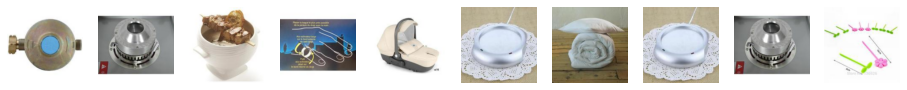

In [191]:
search_similar_image('2804_0.jpg', 10)

6172


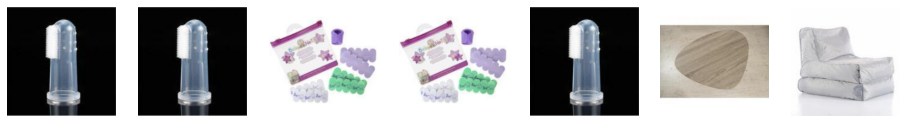

In [199]:
search_similar_image('6172_0.jpg', 7)